In [1]:
%pip install hdbscan networkx

Note: you may need to restart the kernel to use updated packages.


## Features

1. Degree centrality
   - The `nx.algorithms.degree_centrality(G)` method returns a dictionary mapping each node to its degree centrality.
   - The degree centrality for a node `v` is the fraction of nodes to which it is connected.
1. 2nd degree centrality (number of neighbors two edges away)
   - This is scaled by the graph size so the value is between zero and one.
1. 3rd degree centrality (number of neighbors three edges away)
   - This is scaled by the graph size so the value is between zero and one.
1. Betweenness centrality
   - Betweenness centrality of a node `v` is the sum of the fraction of all-pairs shortest paths that pass through `v`.
1. Closeness centrality
   - Closeness centrality of a node `v` is the reciprocal of the average shortest path distance to `v` over all `n-1` reachable nodes.
1. Eigenvector centrality
   - Eigenvector centrality computes the centrality for a node based on the centrality of its neighbors.
   - Eigenvector centrality ranks the likelihood that a node is visited on a random walk of infinite length on the graph.
   - The Eigenvector centrality for node `i` is the `i`-th element of the vector `x` defined by the equation `Ax = λx` where `A` is the adjacency matrix of the graph `G` with eigenvalue `λ`.
1. Clustering Coefficient
   - Clustering coefficient measures the proportion of closed triangles in a node's local neighborhood.  It measures how tightly clustered is a node's neighborhood.
1. Average neighbor degree
   - The average neighborhood degree of a node `v` is the sum of the degrees of the neighbors of `v` divided by the size of its neighborhood.
   - The `nx.algorithms.assortativity.average_neighbor_degree(G)` method returns a dictionary mapping each node to its average neighbor degree.
1. Ratio of degree to 2nd degree
   - This is scaled by the maximum value of this feature so the value is between zero and one.
1. Ratio of 2nd degree to 3rd degree
   - This is scaled by the maximum value of this feature so the value is between zero and one.
1. Distance to nearest leaf
   - This is scaled by the diameter of the graph so the value is between zero and one.
1. Distance to farthest leaf
   - This is scaled by the diameter of the graph so the value is between zero and one.
1. Is in dominating set
   - The `nx.algorithms.approximation.min_weighted_dominating_set(G)` method returns the set of such nodes.
   - This feature's value is `1.0` if the node is in that set and `0.0` otherwise.
1. Is leaf node
   - This is a non-linear transformation of the "distance to nearest leaf" feature.
   - A node is a leaf node if its degree is one.  This means its distance to the nearest leaf is zero since it is a leaf node.
   - This feature's value is `1.0` if the node is a leaf node and `0.0` otherwise.

In [63]:
from collections import Counter
from datetime import datetime
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from urllib.request import urlopen
import gzip
import itertools as it
import matplotlib.colors as mc
import matplotlib.pyplot as mp
import networkx as nx
import numpy as np

In [3]:
G = nx.Graph(tuple(map(int, s.split(' '))) for s in gzip.decompress(urlopen('https://snap.stanford.edu/data/facebook_combined.txt.gz').read()).decode('utf-8').strip().split('\n'))
G.number_of_edges(), G.number_of_nodes()

(88234, 4039)

This is a connected graph since there is only one connected component.  Thus, there is a path between all pairs of nodes.

In [4]:
nx.number_connected_components(G)

1

In [5]:
n1 = len(G) - 1
def ilen(g):
    return sum(map(lambda _: 1, g))
def mark_time(message: str, begin_at: datetime) -> datetime:
    end_at = datetime.now()
    print('{} took {:0.1f} seconds'.format(message, (end_at - begin_at).total_seconds()))
    return end_at
begin_at = datetime.now()
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))
next_at = mark_time('shortest path lengths', begin_at)
degrees = G.degree()
next_at = mark_time('degrees', next_at)
second_degrees = {v: ilen(v for v in shortest_path_lengths[v].values() if v == 2) for v in G}
next_at = mark_time('second degrees', next_at)
third_degrees = {v: ilen(v for v in shortest_path_lengths[v].values() if v == 3) for v in G}
next_at = mark_time('third degrees', next_at)
degree_centralities = nx.degree_centrality(G)
second_degree_centralities = {v: second_degrees[v] / n1 for v in G}
third_degree_centralities = {v: third_degrees[v] / n1 for v in G}
degree_12_ratios = {v: degrees[v] / second_degrees[v] for v in G}
degree_23_ratios = {v: second_degrees[v] / third_degrees[v] for v in G}
next_at = mark_time('degree centralities', next_at)
eccentricities = nx.eccentricity(G, sp=shortest_path_lengths)
next_at = mark_time('eccentricities', next_at)
diameter = nx.diameter(G, eccentricities)
next_at = mark_time(f'diameter {diameter}', next_at)
betweenness_centralities = nx.betweenness_centrality(G)
next_at = mark_time('betweenness centralities', next_at)
closeness_centralities = nx.closeness_centrality(G)
next_at = mark_time('closeness centralities', next_at)
eigenvector_centralities = nx.eigenvector_centrality(G)
next_at = mark_time('eigenvector centralities', next_at)
clustering_coefficients = nx.clustering(G)
next_at = mark_time('clustering coefficients', next_at)
average_neighbor_degrees = nx.average_neighbor_degree(G)
next_at = mark_time('average neighbor degrees', next_at)
dominating_nodes = nx.approximation.min_weighted_dominating_set(G)
next_at = mark_time(f'{len(dominating_nodes)} dominating nodes', next_at)
leaf_nodes = {k for k, v in degrees if v == 1}
nearest_leaf_distances = {v: min(shortest_path_lengths[v][u] for u in leaf_nodes) / diameter for v in G.nodes}
farthest_leaf_distances = eccentricities
next_at = mark_time('leaf distances', next_at)
_ = mark_time('all operations', begin_at)

shortest path lengths took 27.3 seconds
degrees took 0.0 seconds
second degrees took 0.5 seconds
third degrees took 0.6 seconds
degree centralities took 0.0 seconds
eccentricities took 0.1 seconds
diameter 8 took 0.0 seconds
betweenness centralities took 96.9 seconds
closeness centralities took 28.0 seconds
eigenvector centralities took 0.8 seconds
clustering coefficients took 1.6 seconds
average neighbor degrees took 0.0 seconds
433 dominating nodes took 3.6 seconds
leaf distances took 0.1 seconds
all operations took 159.5 seconds


In [6]:
# TODO:  consider leaving values unscaled.
def fn(node):
    return (degree_centralities[node],
            second_degree_centralities[node],
            third_degree_centralities[node],
            betweenness_centralities[node],
            closeness_centralities[node],
            eigenvector_centralities[node],
            clustering_coefficients[node],
            average_neighbor_degrees[node],
            degree_12_ratios[node],
            degree_23_ratios[node],
            nearest_leaf_distances[node],
            farthest_leaf_distances[node],
            1.0 if node in dominating_nodes else 0.0,
            1.0 if node in leaf_nodes else 0.0)

t = (degree_centralities,
     second_degree_centralities,
     third_degree_centralities,
     betweenness_centralities,
     closeness_centralities,
     eigenvector_centralities,
     clustering_coefficients,
     average_neighbor_degrees,
     degree_12_ratios,
     degree_23_ratios,
     nearest_leaf_distances,
     farthest_leaf_distances,
     dominating_nodes,
     leaf_nodes)
minima = tuple(type(d) is dict and min(d.values()) for d in t)
maxima = tuple(type(d) is dict and max(d.values()) for d in t)
def fn(node):
    def fn(d, minimum, maximum):
        v = maximum - minimum
        return (d[node] - minimum) / v
    return tuple(fn(a, b, c) if type(a) is dict else 1.0 if node in a else 0.0 for a, b, c in zip(t, minima, maxima))
X = tuple(map(fn, G))
[min(t) for t in zip(*X)], [max(t) for t in zip(*X)]

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

# HDBSCAN: Density-based Clustering

#### Non-zero HDBSCAN defaults

```
min_cluster_size=5
metric='euclidean'
alpha=1.0, p=None
algorithm='best'
leaf_size=40
approx_min_span_tree=True
core_dist_n_jobs=4
cluster_selection_method='eom'
```

In [7]:
hdbscan = HDBSCAN()
hdbscan.fit(X)
len(set(hdbscan.labels_)), ilen(l for l in hdbscan.labels_ if l < 0)

(107, 904)

In [8]:
def fn(n):
    hdbscan = HDBSCAN(min_cluster_size=n, min_samples=1)
    hdbscan.fit(X)
    return n, len(set(hdbscan.labels_)), len([l for l in hdbscan.labels_ if l < 0])
g = (10 * n for n in range(2, 11))
g = map(fn, g)
print(*g, sep='\n')

(20, 30, 138)
(30, 21, 116)
(40, 20, 116)
(50, 19, 116)
(60, 18, 175)
(70, 16, 226)
(80, 12, 429)
(90, 12, 429)
(100, 12, 429)


In [66]:
hdbscan = HDBSCAN(min_cluster_size=80, min_samples=1)
hdbscan.fit(X)
clusters_to_nodes = tuple((c, i) for i, c in enumerate(hdbscan.labels_))
nodes_to_clusters = {i: c for i, c in enumerate(hdbscan.labels_)}
sorted(Counter(hdbscan.labels_).items())

[(-1, 429),
 (0, 187),
 (1, 111),
 (2, 312),
 (3, 490),
 (4, 106),
 (5, 314),
 (6, 324),
 (7, 103),
 (8, 759),
 (9, 174),
 (10, 730)]

In [10]:
# https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html
spotlight_nodes = {0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980}
[t for t in clusters_to_nodes if t[1] in spotlight_nodes]

[(-1, 0),
 (-1, 107),
 (-1, 348),
 (8, 414),
 (8, 686),
 (8, 698),
 (9, 1684),
 (0, 1912),
 (1, 3437),
 (3, 3980)]

HDBSCAN splits the graph into fewer clusters and noise increases as its `min_cluster_size` parameter increases.

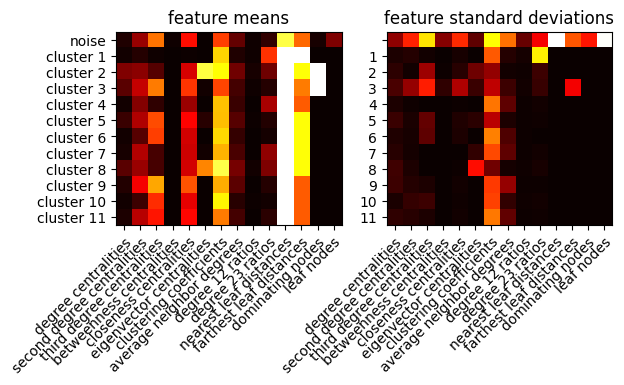

In [11]:
def fn(g, fn):
    g = (X[v] for _, v in g)
    g = map(fn, zip(*g))
    return tuple(g)
Ymean = tuple(fn(v, np.mean) for _, v in it.groupby(sorted(clusters_to_nodes), lambda t: t[0]))
Ystd = tuple(fn(v, np.std) for _, v in it.groupby(sorted(clusters_to_nodes), lambda t: t[0]))
plot1 = mp.subplot(121)
xlabels = ('degree centralities',
     'second degree centralities',
     'third degree centralities',
     'betweenness centralities',
     'closeness centralities',
     'eigenvector centralities',
     'clustering coefficients',
     'average neighbor degrees',
     'degree 12 ratios',
     'degree 23 ratios',
     'nearest leaf distances',
     'farthest leaf distances',
     'dominating nodes',
     'leaf nodes')
plot1.set_title('feature means')
plot1.set_xticks(range(len(xlabels)), labels=xlabels, rotation=45, ha="right", rotation_mode="anchor")
plot1.set_yticks(range(len(Ymean)), labels=tuple(f'cluster {i}' if i else 'noise' for i in range(len(Ymean))))
mp.imshow(Ymean, cmap='hot', interpolation='nearest')
plot2 = mp.subplot(122)
plot2.set_title('feature standard deviations')
plot2.set_xticks(range(len(xlabels)), labels=xlabels, rotation=45, ha="right", rotation_mode="anchor")
plot2.set_yticks(range(len(Ystd)), labels=tuple(str(i) if i else '' for i in range(len(Ymean))))
mp.imshow(Ystd, cmap='hot', interpolation='nearest')
mp.show()

In [12]:
# https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html
spotlight_nodes = {0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980}
[(v, nodes_to_clusters[v]) for v in sorted(spotlight_nodes)]

[(0, -1),
 (107, -1),
 (348, -1),
 (414, 8),
 (686, 8),
 (698, 8),
 (1684, 9),
 (1912, 0),
 (3437, 1),
 (3980, 3)]

In [13]:
# https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html
l = list(sorted({v for v, _ in [(107, 0.4805180785560152),
    (1684, 0.3377974497301992),
    (3437, 0.23611535735892905),
    (1912, 0.2292953395868782),
    (1085, 0.14901509211665306),
    (0, 0.14630592147442917),
    (698, 0.11533045020560802),
    (567, 0.09631033121856215)]+[(107, 1045),
    (1684, 792),
    (1912, 755),
    (3437, 547),
    (0, 347),
    (2543, 294),
    (2347, 291),
    (1888, 254)]+[(107, 0.4805180785560152),
    (1684, 0.3377974497301992),
    (3437, 0.23611535735892905),
    (1912, 0.2292953395868782),
    (1085, 0.14901509211665306),
    (0, 0.14630592147442917),
    (698, 0.11533045020560802),
    (567, 0.09631033121856215)]+[(107, 0.45969945355191255),
    (58, 0.3974018305284913),
    (428, 0.3948371956585509),
    (563, 0.3939127889961955),
    (1684, 0.39360561458231796),
    (171, 0.37049270575282134),
    (348, 0.36991572004397216),
    (483, 0.3698479575013739)]+[(1912, 0.09540696149067629),
    (2266, 0.08698327767886552),
    (2206, 0.08605239270584342),
    (2233, 0.08517340912756598),
    (2464, 0.08427877475676092),
    (2142, 0.08419311897991796),
    (2218, 0.0841557356805503),
    (2078, 0.08413617041724979),
    (2123, 0.08367141238206226),
    (1993, 0.0835324284081597)]}))
[(v, nodes_to_clusters[v]) for v in sorted(l)]

[(0, -1),
 (58, -1),
 (107, -1),
 (171, -1),
 (348, -1),
 (428, 8),
 (483, 8),
 (563, -1),
 (567, 8),
 (698, 8),
 (1085, 8),
 (1684, 9),
 (1888, 0),
 (1912, 0),
 (1993, 0),
 (2078, 10),
 (2123, 10),
 (2142, 4),
 (2206, 4),
 (2218, 4),
 (2233, 10),
 (2266, 10),
 (2347, 2),
 (2464, 10),
 (2543, 10),
 (3437, 1)]

Unsurprisingly, the noise has significant variance in most features.  Some nodes that might be considered "important" HDBSCAN considers noise.  For example, node 107 has the highest degree centrality of `0.259`, meaning this Facebook user is friends with about 26% of the whole network.  This "importance" makes it an outlier so HDBSCAN considers it noise.  Another instance is node 0.  It also has a high degree and centrality.  Nodes 58, 171, and 348 have high closeness centralities and HDBSCAN considers them noise, as well.  Other nodes with high degrees and centralities are not noise because the values of their other features are close enough those of other nodes.

In [14]:
[(n, nodes_to_clusters[n]) for n in (107, 0, 171, 348)]

[(107, -1), (0, -1), (171, -1), (348, -1)]

graph visualization took 19.3 seconds


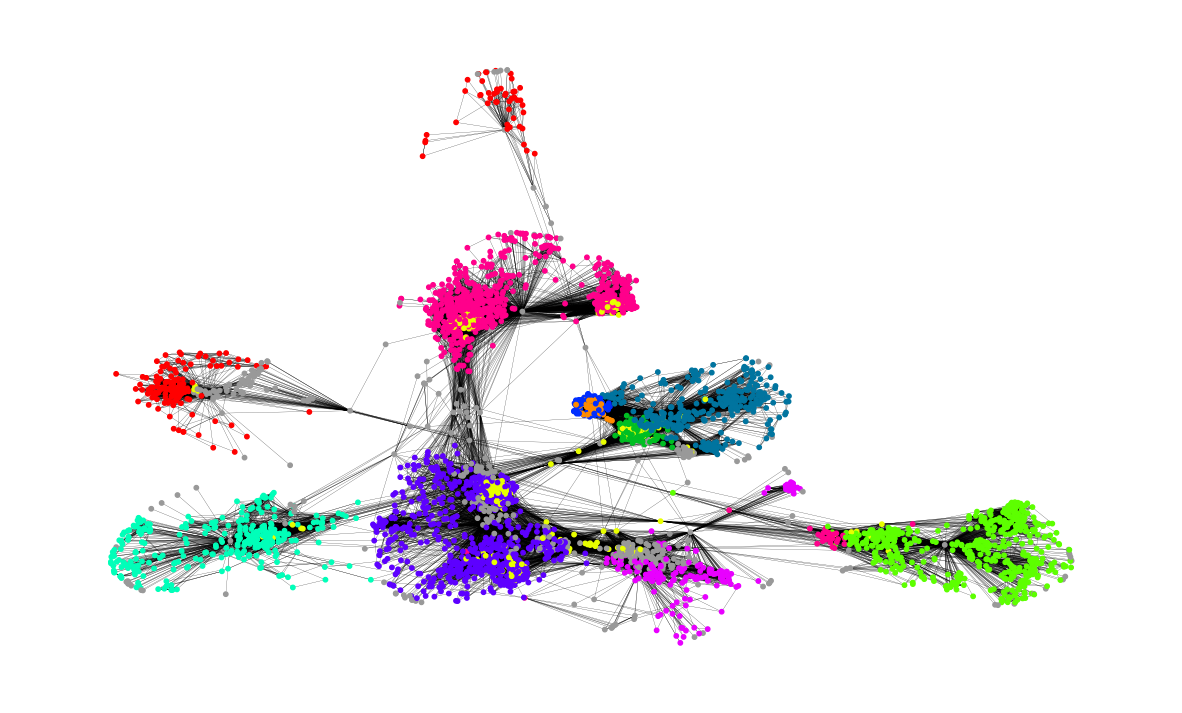

In [23]:
def make_colors():
    n = 11
    g = (mc.to_hex(mc.hsv_to_rgb((v / n, 1, 0.75 if v == 4 else 0.625 if v == 6 else 1))) for v in range(n))
    g = it.chain(['#999'], g)
    return list(g)
begin_at = datetime.now()
colors = make_colors() #[mc.to_rgb('yellow'), mc.to_rgb('fuchsia'), mc.to_rgb('indigo')] + list(mc.TABLEAU_COLORS.values())
node_colors = [colors[c + 1] for c, _ in clusters_to_nodes]
mp.figure(figsize=(15, 9))
mp.axis("off")
pos = nx.spring_layout(G, iterations=24, seed=9)
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=node_colors)
_ = mark_time('graph visualization', begin_at)

# K-Means: Proximity-based Clustering

I chose twelve clusters to match the number of clusters, including noise, HDBSCAN found.

In [76]:
kmeans = KMeans(n_clusters=12, n_init='auto', random_state=9)
kmeans.fit(X)
sorted(Counter(kmeans.labels_).items())

[(0, 424),
 (1, 321),
 (2, 23),
 (3, 852),
 (4, 459),
 (5, 112),
 (6, 52),
 (7, 641),
 (8, 48),
 (9, 492),
 (10, 476),
 (11, 139)]

graph visualization took 19.7 seconds


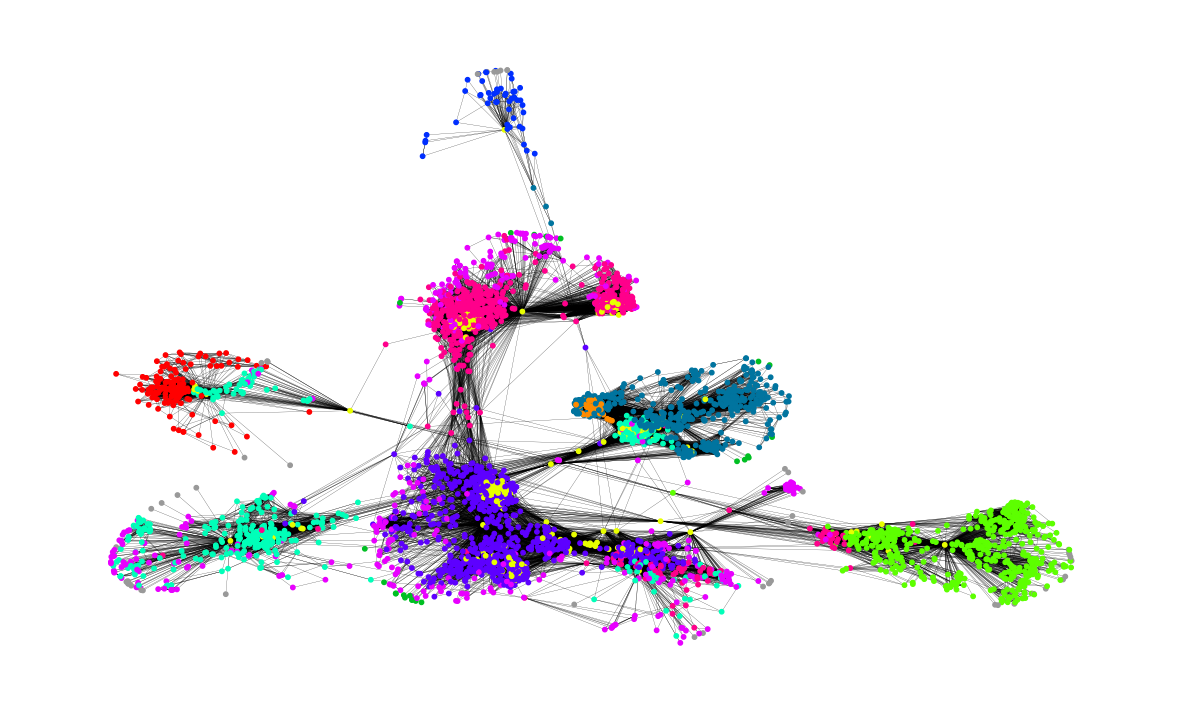

In [82]:
begin_at = datetime.now()
colors = make_colors()
colors = [colors[i] for i in (6, 3, 5, 9, 7, 2, 0, 11, 8, 4, 10, 1)]
node_colors = [colors[c] for c in kmeans.labels_]
mp.figure(figsize=(15, 9))
mp.axis("off")
pos = nx.spring_layout(G, iterations=24, seed=9)
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=node_colors)
_ = mark_time('graph visualization', begin_at)